## Settings

In [2]:
%cd /content/drive/MyDrive/Dyetec

/content/drive/MyDrive/Dyetec


In [ ]:
!pip install colormath

In [4]:
import os
import random
import pandas as pd
import numpy as np
pd.options.display.max_rows = 100
pd.options.display.max_columns = 50

import matplotlib.pyplot as plt
import seaborn as sns

from colormath.color_objects import LabColor
from colormath.color_diff import delta_e_cmc

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import plot_importance
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

### Configurations

In [5]:
#====  RandomForest  ====
N_ESTIMATORS = 100
# N_ESTIMATORS = 200
MAX_DEPTH = 20
CRITERION = 'squared_error'  # 'absolute_error'
MAX_SAMPLES = 1.0            # range (0, 1.0)

#=====  XGBoost  =====
BOOSTER = 'gbtree' # default. Gradient Boosting tree
LR = 0.1
MAX_DEPTH = 20
N_ESTIMATORS = 100
OBJECTIVE = 'reg:squarederror'
SILENT = False
SUBSAMPLE = 1.0  # Subsample ratio from the training set

colsample_bylevel = 1.0
colsample_bytree = 1.0
EARLY_STOPPING_ROUNDS = 10  # 에러가 n번 증가하면 학습 중단, default 10
GAMMA = 0.0
MAX_DELTA_STEP = 0.0
min_child_weights = 1.0 # Minimum sum of weights needed in each child node for a split.
num_parallel_tree = 1

# 'dart'인 경우에만 적용 - overfitting 방지
NORMALIZE_TYPE = 'tree'  # how to normalize trees, default 'tree'
ONE_DROP = True          # 1개 이상의 트리를 드롭아웃
RATE_DROP = 0.5          # 각 트리를 드롭아웃할 확률, default 0.0
REG_ALPHA = 0.2          # L1 regularization on the weights, default 0.0
REG_LAMBDA = 0.8         # L2 regularization on the weights, default 1.0
SAMPLE_TYPE = 'weighted' # 드롭아웃 확률을 트리의 가중치에 비례하게, default 'uniform'
SKIP_DROP = 0.2          # skipping the dropout during a given iteration, default 0.0


In [6]:
SEED = 42
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)

seed_everything(SEED)

## Data Loading

In [7]:
df = pd.read_excel('rawdata.xlsx', skiprows=2)
df.drop(labels=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df.drop(columns=['태그'], inplace=True)
df = df.iloc[:, :54]

In [8]:
# 컬럼 순서 변경
cols = list(df.columns[[0,2,1]].values) + list(df.columns[3:].values)
df = df[cols]
df

,Lab 후가공 후 검사_L*,Lab 후가공 후 검사_a*,Lab 후가공 후 검사_b*,Dianix Yellow AM-2R,Dianix Red AM-SLR,Dianix Blue AM-2G,Dorosperse Yellow KKL,Synolon Yellow AK,Dorosperse Red KKL,Synolon Red AK,Synolon Blue AK,Dorosperse Blue KKL,Dorosperse Yellow KKL_prop,Dorosperse Red KKL_prop,Dianix Red AM-SLR_prop,Dianix Blue AM-2G_prop,Dianix Yellow AM-2R_prop,Dorosperse Blue KKL_prop,Synolon Yellow AK_prop,Synolon Red AK_prop,Synolon Blue AK_prop,Dianix Yellow Brown AM-R,Synofast 28,Dorosperse Dark Grey KKL,Dorosperse B/K KKL,...,Synolon Dark Grey AK,Lab 염색 상승온도 #3 유지시간,Lab 염색 상승속도 #3,Lab 염색 상승온도 #3,배합_Sera Fast P-UVC,배합_UVK-400 H/C,배합_Fadex® TS liq,후처리_Sera Con M-FAS,Lab 염색 상승속도 #2,Lab 염색 하강속도 #1,Synofast 28_prop,Dianix Grey AM-SLR_prop,전처리_CH3COOH,배합_빙초산,Dorosperse Dark Grey KKL_prop,Dorosperse B/K KKL_prop,Dianix Black AM-SLR_prop,Dianix Yellow Brown AM-R_prop,배합_UVK-200,제직_중량_생지,Dorosperse Brown K-3LR_prop,Lab 염색 상승속도 #1,후처리_NaOH,Synolon Black AK-NB_prop,Synolon Dark Grey AK_prop
0,50.510,10.5500,9.480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,...,0.0,60.0,1.500000,136.0,0.0,0.0,0.0,2.0,0.75,2.00000,1.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,237.0,0.0,1.5,2.0,0.0,0.0
1,51.460,10.0100,9.790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,...,0.0,60.0,1.500000,136.0,4.0,0.0,4.0,2.0,0.75,2.00000,1.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,237.0,0.0,1.5,2.0,0.0,0.0
2,51.870,10.2400,9.480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,...,0.0,60.0,1.500000,136.0,0.0,4.0,0.0,2.0,0.75,2.00000,1.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,4.0,237.0,0.0,1.5,2.0,0.0,0.0
3,48.930,10.9200,9.570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,60.0,1.500000,136.0,0.0,0.0,0.0,2.0,0.75,2.00000,1.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,237.0,0.0,1.5,2.0,0.0,0.0
4,49.580,10.5200,9.790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,60.0,1.500000,136.0,4.0,0.0,4.0,2.0,0.75,2.00000,1.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,237.0,0.0,1.5,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,48.260,57.3950,50.385,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.666667,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,70.0,1.458333,135.0,0.0,0.0,0.0,4.0,0.75,1.97222,0.0,0.0,1.0,0.2,0.0,0.0,0.0,0.0,0.0,242.0,0.0,1.5,2.0,0.0,0.0
1680,48.250,57.0850,50.180,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.666667,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,80.0,1.458333,135.0,0.0,0.0,0.0,4.0,0.75,1.97222,0.0,0.0,1.0,0.2,0.0,0.0,0.0,0.0,0.0,242.0,0.0,1.5,2.0,0.0,0.0
1681,69.100,30.2775,84.880,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,60.0,1.458333,135.0,0.0,0.0,0.0,4.0,0.75,1.97222,0.0,0.0,1.0,0.2,0.0,0.0,0.0,0.0,0.0,242.0,0.0,1.5,2.0,0.0,0.0
1682,69.835,29.0850,84.570,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,60.0,1.458333,135.0,0.0,0.0,2.0,4.0,0.75,1.97222,0.0,0.0,1.0,0.2,0.0,0.0,0.0,0.0,0.0,242.0,0.0,1.5,2.0,0.0,0.0


### 컬럼명 변경

In [9]:
kr2en = {'Lab 후가공 후 검사_L*': 'L*', 
         'Lab 후가공 후 검사_a*': 'a*', 
         'Lab 후가공 후 검사_b*': 'b*',
         '전처리_CH3COOH': 'prep_CH3COOH', 
         '제직_중량_생지': 'weaving_dough', 
         '배합_Sera Fast P-UVC': 'comb_Sera Fast', 
         '배합_UVK-400 H/C': 'comb_UVK400', 
         '배합_Fadex® TS liq': 'comb_Fadex', 
         '배합_빙초산': 'comb_acid',
         '배합_UVK-200': 'comb_UVK200',
         'Lab 염색 상승속도 #1': 'dye_up_rate1', 
         'Lab 염색 상승속도 #2': 'dye_up_rate2', 
         'Lab 염색 상승속도 #3': 'dye_up_rate3', 
         'Lab 염색 상승온도 #3': 'dye_up_temp3', 
         'Lab 염색 상승온도 #3 유지시간': 'dye_up_temp3_hold', 
         'Lab 염색 하강속도 #1': 'dye_down_rate1',
         '후처리_Sera Con M-FAS': 'after_Sera', 
         '후처리_NaOH': 'after_NaOH'
}

for col in df.columns:
    if col not in kr2en.keys(): continue
    df.rename(columns={col: kr2en[col]}, inplace=True)
# df.columns

### Binary Features

In [10]:
nuniq = df.nunique()
nuniq

L*                               1544
a*                               1413
b*                               1458
Dianix Yellow AM-2R                21
Dianix Red AM-SLR                  21
Dianix Blue AM-2G                  21
Dorosperse Yellow KKL              21
Synolon Yellow AK                  21
Dorosperse Red KKL                 21
Synolon Red AK                     21
Synolon Blue AK                    21
Dorosperse Blue KKL                21
Dorosperse Yellow KKL_prop         18
Dorosperse Red KKL_prop            18
Dianix Red AM-SLR_prop             18
Dianix Blue AM-2G_prop             18
Dianix Yellow AM-2R_prop           18
Dorosperse Blue KKL_prop           18
Synolon Yellow AK_prop             18
Synolon Red AK_prop                18
Synolon Blue AK_prop               18
Dianix Yellow Brown AM-R           12
Synofast 28                        12
Dorosperse Dark Grey KKL           12
Dorosperse B/K KKL                 12
Dianix Black AM-SLR                12
Dorosperse B

In [11]:
bicols = nuniq[nuniq == 2].index.values
over2 = nuniq[nuniq > 2].index.values
print(f"Number of Binary Features: {len(bicols)}")

Number of Binary Features: 16


# 염색 하강속도1

In [12]:
target = bicols[0]
df[target].value_counts()

1.97222    1522
2.00000     162
Name: dye_down_rate1, dtype: int64

In [34]:
df1, df2 = [ df.loc[df[target] == v, over2] for v in sorted(df[target].unique()) ]
df1.shape, df2.shape

((1522, 38), (162, 38))

## I. 염색 하강속도1 = 1.97222

In [89]:
X1, y1 = df1.iloc[:,3:], df1.iloc[:,:3]
print(f'=== {target} = {sorted(df[target].unique())[0]} ===')
print('Total:', X1.shape, y1.shape)

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=SEED)
print('Train:', X_train.shape, y_train.shape)
print('Test :', X_test.shape, y_test.shape)

=== dye_down_rate1 = 1.97222 ===
Total: (1522, 35) (1522, 3)
Train: (1217, 35) (1217, 3)
Test : (305, 35) (305, 3)


In [38]:
# Case 1. 평균, 표준편차 분포
print(f"L* : mean = {df1['L*'].mean():.4f}, std = {df1['L*'].std():.4f}")
print(f"a* : mean = {df1['a*'].mean():.4f}, std = {df1['a*'].std():.4f}")
print(f"b* : mean = {df1['b*'].mean():.4f}, std = {df1['b*'].std():.4f}")

L* : mean = 52.8434, std = 21.2576
a* : mean = 13.2437, std = 22.5964
b* : mean = 11.6233, std = 28.9184


### 1) Random Forest

In [14]:
model_rf = RandomForestRegressor(n_estimators=N_ESTIMATORS, 
                              max_depth=MAX_DEPTH,
                              criterion=CRITERION,
                              max_samples=MAX_SAMPLES,
                              warm_start=False,
                              random_state=SEED)

In [91]:
model_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_samples=1.0, random_state=42)

In [92]:
y_train_pred_rf = model_rf.predict(X_train)
df_train_pred_rf = pd.DataFrame(y_train_pred_rf, columns=['L_train_pred', 'a_train_pred', 'b_train_pred'])

y_pred_rf = model_rf.predict(X_test)
df_pred_rf = pd.DataFrame(y_pred_rf, columns=['L_pred', 'a_pred', 'b_pred'])

### 2) XGBoost

In [24]:
model_xgb = MultiOutputRegressor(xgb.XGBRegressor(
    booster=BOOSTER, # 'dart': Adds dropout to the standard gradient boosting algorithm
    learning_rate=LR,
    max_depth=MAX_DEPTH,
    n_estimators=N_ESTIMATORS,
    objective=OBJECTIVE,
    silent=SILENT,
    subsample=SUBSAMPLE,
))

In [94]:
model_xgb.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(max_depth=20,
                                            objective='reg:squarederror',
                                            silent=False, subsample=1.0))

In [95]:
y_pred = model_xgb.predict(X_test)
df_pred = pd.DataFrame(y_pred, columns=['L_pred', 'a_pred', 'b_pred'])

y_train_pred = model_xgb.predict(X_train)
df_train_pred = pd.DataFrame(y_train_pred, columns=['L_train_pred', 'a_train_pred', 'b_train_pred'])

### Performance Evaluation
- Lab 한꺼번에 학습 및 예측한 결과만!!
- R-sqaured, MSE
- CMC 2:1 색차값

In [96]:
print('===== Random Forest =====')
print(f'[Train] R-squared: {round(model_rf.score(X_train, y_train),5)}')
print(f'[Test]  R-squared: {round(model_rf.score(X_test, y_test),5)}')

print(f'\n[Train] MSE: {round(mean_squared_error(y_train, y_train_pred_rf), 4)}')
print(f'[Test]  MSE: {round(mean_squared_error(y_test, y_pred_rf),4)}') # MSE 차이가 꽤 크다. 오버피팅 개선하기!


print('\n======  XGBoost  ======')
print(f'[Train] R-squared: {round(model_xgb.score(X_train, y_train),5)}')
print(f'[Test]  R-squared: {round(model_xgb.score(X_test, y_test),5)}')

print(f'\n[Train] MSE: {round(mean_squared_error(y_train, y_train_pred), 4)}')
print(f'[Test]  MSE: {round(mean_squared_error(y_test, y_pred),4)}')

===== Random Forest =====
[Train] R-squared: 0.97348
[Test]  R-squared: 0.9388

[Train] MSE: 13.4466
[Test]  MSE: 31.0319

======  XGBoost  ======
[Train] R-squared: 0.99996
[Test]  R-squared: 0.97731

[Train] MSE: 0.0188
[Test]  MSE: 12.213


### CMC 색차값, ΔE 계산

In [97]:
def compute_delta_e(y_test, y_pred):
    delta_E = []
    for i, (L_pred, a_pred, b_pred) in enumerate(y_pred):
        L_test, a_test, b_test = y_test.iloc[i].values
        target_color = LabColor(L_test, a_test, b_test)
        pred_color = LabColor(L_pred, a_pred, b_pred)
        delta_E.append(delta_e_cmc(target_color, pred_color, pl=2, pc=1))
    return delta_E

In [105]:
print('===== Random Forest =====')
# Train Dataset
df_train_pred_rf['Delta_E'] = compute_delta_e(y_train, y_train_pred_rf)
df_train_pred_rf['Below 1'] = (df_train_pred_rf['Delta_E'] < 1)
print(f"[Train] ΔE < 1 : {df_train_pred_rf['Below 1'].sum()} / {len(df_train_pred_rf)} = {df_train_pred_rf['Below 1'].mean():.4f}")
print(f"[Train] Average of ΔE : {df_train_pred_rf['Delta_E'].mean():.4f}")

# Test Dataset
df_pred_rf['Delta_E'] = compute_delta_e(y_test, y_pred_rf)
df_pred_rf['Below 1'] = (df_pred_rf['Delta_E'] < 1)
print(f"\n[Test]  ΔE < 1 : {df_pred_rf['Below 1'].sum()} / {len(df_pred_rf)} = {df_pred_rf['Below 1'].mean():.4f}")
print(f"[Test]  Average of ΔE : {df_pred_rf['Delta_E'].mean():.4f}")


print('\n\n======  XGBoost  ======')
# Train Dataset
df_train_pred['Delta_E'] = compute_delta_e(y_train, y_train_pred)
df_train_pred['Below 1'] = (df_train_pred['Delta_E'] < 1)
print(f"[Train] ΔE < 1 : {df_train_pred['Below 1'].sum()} / {len(df_train_pred)} = {df_train_pred['Below 1'].mean():.4f}")
print(f"[Train] Average of ΔE : {df_train_pred['Delta_E'].mean():.4f}")

# Test Dataset
df_pred['Delta_E'] = compute_delta_e(y_test, y_pred)
df_pred['Below 1'] = (df_pred['Delta_E'] < 1)
print(f"\n[Test]  ΔE < 1 : {df_pred['Below 1'].sum()} / {len(df_pred)} = {df_pred['Below 1'].mean():.4f}")
print(f"[Test]  Average of ΔE : {df_pred['Delta_E'].mean():.4f}")

===== Random Forest =====
[Train] ΔE < 1 : 122 / 129 = 0.9457
[Train] Average of ΔE : 0.4226

[Test]  ΔE < 1 : 23 / 33 = 0.6970
[Test]  Average of ΔE : 0.9899


======  XGBoost  ======
[Train] ΔE < 1 : 129 / 129 = 1.0000
[Train] Average of ΔE : 0.0198

[Test]  ΔE < 1 : 31 / 33 = 0.9394
[Test]  Average of ΔE : 0.5599


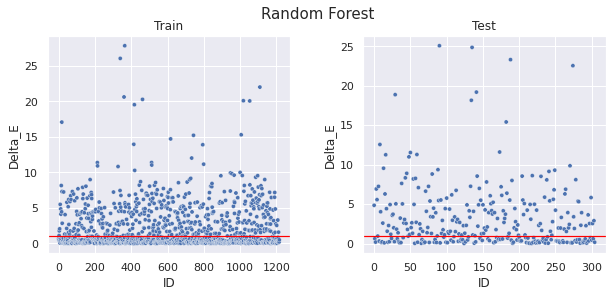

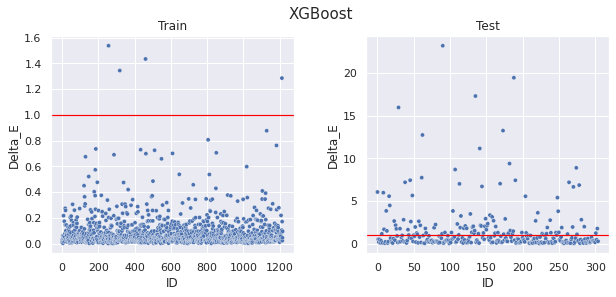

In [99]:
# Random Forest
fig, axes = plt.subplots(1,2, figsize=(10,4))
plt.subplots_adjust(wspace=0.3)
sns.set_theme(style='darkgrid')
fig.suptitle('Random Forest', fontsize=15)

sns.scatterplot(ax=axes[0], x=df_train_pred_rf.index, y=df_train_pred_rf['Delta_E'], size=1, legend=False)
axes[0].axhline(1.0, 0, 1, color='red', linewidth=1.2)
axes[0].set_title('Train', fontsize=12)
axes[0].set_xlabel('ID')

sns.scatterplot(ax=axes[1], x=df_pred_rf.index, y=df_pred_rf['Delta_E'], size=1, legend=False)
axes[1].axhline(1.0, 0, 1, color='red', linewidth=1.2)
axes[1].set_title('Test', fontsize=12)
axes[1].set_xlabel('ID')
plt.show()


# XGBoost
fig, axes = plt.subplots(1,2, figsize=(10,4))
plt.subplots_adjust(wspace=0.3)
sns.set_theme(style='darkgrid')
fig.suptitle('XGBoost', fontsize=15)

sns.scatterplot(ax=axes[0], x=df_train_pred.index, y=df_train_pred['Delta_E'], size=1, legend=False)
axes[0].axhline(1.0, 0, 1, color='red', linewidth=1.2)
axes[0].set_title('Train', fontsize=12)
axes[0].set_xlabel('ID')

sns.scatterplot(ax=axes[1], x=df_pred.index, y=df_pred['Delta_E'], size=1, legend=False)
axes[1].axhline(1.0, 0, 1, color='red', linewidth=1.2)
axes[1].set_title('Test', fontsize=12)
axes[1].set_xlabel('ID')
plt.show()

## II. 염색 하강속도1 = 2.0

In [100]:
X2, y2 = df2.iloc[:,3:], df2.iloc[:,:3]
print(f'=== {target} = {sorted(df[target].unique())[1]} ===')
print('Total:', X2.shape, y2.shape)

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=SEED)
print('Train:', X_train.shape, y_train.shape)
print('Test :', X_test.shape, y_test.shape)

=== dye_down_rate1 = 2.0 ===
Total: (162, 35) (162, 3)
Train: (129, 35) (129, 3)
Test : (33, 35) (33, 3)


In [ ]:
# Case 2. 평균, 표준편차 분포
print(f"L* : mean = {df2['L*'].mean():.4f}, std = {df2['L*'].std():.4f}")
print(f"a* : mean = {df2['a*'].mean():.4f}, std = {df2['a*'].std():.4f}")
print(f"b* : mean = {df2['b*'].mean():.4f}, std = {df2['b*'].std():.4f}")

### 1) Random Forest

In [101]:
model_rf.fit(X_train, y_train)

y_train_pred_rf = model_rf.predict(X_train)
df_train_pred_rf = pd.DataFrame(y_train_pred_rf, columns=['L_train_pred', 'a_train_pred', 'b_train_pred'])

y_pred_rf = model_rf.predict(X_test)
df_pred_rf = pd.DataFrame(y_pred_rf, columns=['L_pred', 'a_pred', 'b_pred'])

### 2) XGBoost

In [102]:
model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)
df_pred = pd.DataFrame(y_pred, columns=['L_pred', 'a_pred', 'b_pred'])

y_train_pred = model_xgb.predict(X_train)
df_train_pred = pd.DataFrame(y_train_pred, columns=['L_train_pred', 'a_train_pred', 'b_train_pred'])

### Performance Evaluation

In [103]:
print('===== Random Forest =====')
print(f'[Train] R-squared: {round(model_rf.score(X_train, y_train),5)}')
print(f'[Test]  R-squared: {round(model_rf.score(X_test, y_test),5)}')

print(f'\n[Train] MSE: {round(mean_squared_error(y_train, y_train_pred_rf), 4)}')
print(f'[Test]  MSE: {round(mean_squared_error(y_test, y_pred_rf),4)}') # MSE 차이가 꽤 크다. 오버피팅 개선하기!


print('\n======  XGBoost  ======')
print(f'[Train] R-squared: {round(model_xgb.score(X_train, y_train),5)}')
print(f'[Test]  R-squared: {round(model_xgb.score(X_test, y_test),5)}')

print(f'\n[Train] MSE: {round(mean_squared_error(y_train, y_train_pred), 4)}')
print(f'[Test]  MSE: {round(mean_squared_error(y_test, y_pred),4)}')

===== Random Forest =====
[Train] R-squared: 0.99833
[Test]  R-squared: 0.98458

[Train] MSE: 0.3658
[Test]  MSE: 1.8188

======  XGBoost  ======
[Train] R-squared: 1.0
[Test]  R-squared: 0.99706

[Train] MSE: 0.0007
[Test]  MSE: 0.477


### CMC 색차값, ΔE 계산

In [104]:
print('===== Random Forest =====')
# Train Dataset
df_train_pred_rf['Delta_E'] = compute_delta_e(y_train, y_train_pred_rf)
df_train_pred_rf['Below 1'] = (df_train_pred_rf['Delta_E'] < 1)
print(f"[Train] ΔE < 1 : {df_train_pred_rf['Below 1'].sum()} / {len(df_train_pred_rf)} = {df_train_pred_rf['Below 1'].mean():.4f}")
print(f"[Train] Average of ΔE : {df_train_pred_rf['Delta_E'].mean():.4f}")

# Test Dataset
df_pred_rf['Delta_E'] = compute_delta_e(y_test, y_pred_rf)
df_pred_rf['Below 1'] = (df_pred_rf['Delta_E'] < 1)
print(f"\n[Test]  ΔE < 1 : {df_pred_rf['Below 1'].sum()} / {len(df_pred_rf)} = {df_pred_rf['Below 1'].mean():.4f}")
print(f"[Test]  Average of ΔE : {df_pred_rf['Delta_E'].mean():.4f}")


print('\n\n======  XGBoost  ======')
# Train Dataset
df_train_pred['Delta_E'] = compute_delta_e(y_train, y_train_pred)
df_train_pred['Below 1'] = (df_train_pred['Delta_E'] < 1)
print(f"[Train] ΔE < 1 : {df_train_pred['Below 1'].sum()} / {len(df_train_pred)} = {df_train_pred['Below 1'].mean():.4f}")
print(f"[Train] Average of ΔE : {df_train_pred['Delta_E'].mean():.4f}")

# Test Dataset
df_pred['Delta_E'] = compute_delta_e(y_test, y_pred)
df_pred['Below 1'] = (df_pred['Delta_E'] < 1)
print(f"\n[Test]  ΔE < 1 : {df_pred['Below 1'].sum()} / {len(df_pred)} = {df_pred['Below 1'].mean():.4f}")
print(f"[Test]  Average of ΔE : {df_pred['Delta_E'].mean():.4f}")

===== Random Forest =====
[Train] ΔE < 1 : 122 / 129 = 0.9457
[Train] Average of ΔE : 0.4226

[Test]  ΔE < 1 : 23 / 33 = 0.6970
[Test]  Average of ΔE : 0.9899


======  XGBoost  ======
[Train] ΔE < 1 : 129 / 129 = 1.0000
[Train] Average of ΔE : 0.0198

[Test]  ΔE < 1 : 31 / 33 = 0.9394
[Test]  Average of ΔE : 0.5599


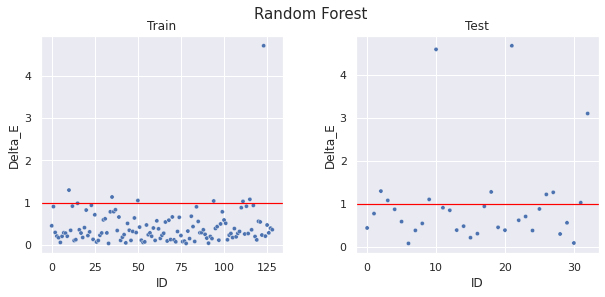

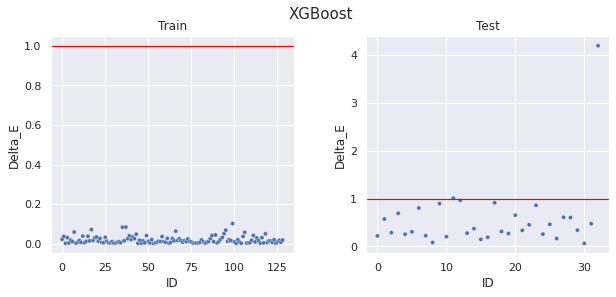

In [106]:
# Random Forest
fig, axes = plt.subplots(1,2, figsize=(10,4))
plt.subplots_adjust(wspace=0.3)
sns.set_theme(style='darkgrid')
fig.suptitle('Random Forest', fontsize=15)

sns.scatterplot(ax=axes[0], x=df_train_pred_rf.index, y=df_train_pred_rf['Delta_E'], size=1, legend=False)
axes[0].axhline(1.0, 0, 1, color='red', linewidth=1.2)
axes[0].set_title('Train', fontsize=12)
axes[0].set_xlabel('ID')

sns.scatterplot(ax=axes[1], x=df_pred_rf.index, y=df_pred_rf['Delta_E'], size=1, legend=False)
axes[1].axhline(1.0, 0, 1, color='red', linewidth=1.2)
axes[1].set_title('Test', fontsize=12)
axes[1].set_xlabel('ID')
plt.show()


# XGBoost
fig, axes = plt.subplots(1,2, figsize=(10,4))
plt.subplots_adjust(wspace=0.3)
sns.set_theme(style='darkgrid')
fig.suptitle('XGBoost', fontsize=15)

sns.scatterplot(ax=axes[0], x=df_train_pred.index, y=df_train_pred['Delta_E'], size=1, legend=False)
axes[0].axhline(1.0, 0, 1, color='red', linewidth=1.2)
axes[0].set_title('Train', fontsize=12)
axes[0].set_xlabel('ID')

sns.scatterplot(ax=axes[1], x=df_pred.index, y=df_pred['Delta_E'], size=1, legend=False)
axes[1].axhline(1.0, 0, 1, color='red', linewidth=1.2)
axes[1].set_title('Test', fontsize=12)
axes[1].set_xlabel('ID')
plt.show()

# 함수 미완성

In [ ]:
def train_predict(df_origin, target, model):
    '''
    target = L*, a*, b*
    model = RandomForestRegressor(), XGBRegressor()
    '''
    target_values = sorted(df_origin[target].unique()) # 2 elements
    df_split, df_train_preds, df_preds = [], [], []

    for i, v in enumerate(target_values):
        df = df_origin.loc[df_origin[target] == v, over2]
        X, y = df.iloc[:,3:], df.iloc[:,:3]
        print(f"\n=== Case {i+1}) {target} = {v} ===")
        print('Total:', X.shape, y.shape)

        # Train, Test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
        print('Train:', X_train.shape, y_train.shape)
        print('Test :', X_test.shape, y_test.shape)

        # Model Training - Random Forest / XGBoost
        # if model
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        df_train_pred = pd.DataFrame(y_train_pred, columns=['L_train_pred', 'a_train_pred', 'b_train_pred'])

        # Prediction
        y_pred = model.predict(X_test)
        df_pred = pd.DataFrame(y_pred, columns=['L_pred', 'a_pred', 'b_pred'])

        # Evaluation
        print(f'\n[Train] R-squared: {round(model.score(X_train, y_train),5)}')
        print(f'[Test]  R-squared: {round(model.score(X_test, y_test),5)}')
        print(f'\n[Train] MSE: {round(mean_squared_error(y_train, y_train_pred), 4)}')
        print(f'[Test]  MSE: {round(mean_squared_error(y_test, y_pred),4)}')

        df_split.append(df)
        df_train_preds.append(df_train_pred)
        df_preds.append(df_pred)

    return df_split, df_train_preds, df_preds

In [ ]:
df_split, df_train_preds, df_preds = train_predict(df, target, model_xgb)